In [5]:
import re
import bs4
from bs4 import BeautifulSoup
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
def review_to_words(review, string = True):
    # Remove non-words
    text = BeautifulSoup(review).get_text()
    # Remove non-letters
    text = re.sub("[^a-zA-Z]"," ", text)
    # Convert words to lower case and split them
    words = text.lower().split()
    # Remove stop words
    stops = set(stopwords.words("english"))
    words = [w for w in words if not w in stops]
    return " ".join(words)

In [7]:
import pandas as pd

In [8]:
train_df = pd.read_json('../processed_data/train.json')
test_df = pd.read_json('../processed_data/test.json')

train_df['words'] = train_df['text'].apply(review_to_words)
test_df['words'] = test_df['text'].apply(review_to_words)

clean_train_reviews = train_df['words'].tolist()
clean_test_reviews = test_df['words'].tolist()
clean_train_reviews[0]

'bromwell high cartoon comedy ran time programs school life teachers years teaching profession lead believe bromwell high satire much closer reality teachers scramble survive financially insightful students see right pathetic teachers pomp pettiness whole situation remind schools knew students saw episode student repeatedly tried burn school immediately recalled high classic line inspector sack one teachers student welcome bromwell high expect many adults age think bromwell high far fetched pity'

In [9]:
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [10]:
# Initialize a bag of words  
vectorizer = CountVectorizer(analyzer = "word", max_features = 5000) 

# Fit transform the data
train_bow = vectorizer.fit_transform(clean_train_reviews).toarray()
test_bow = vectorizer.transform(clean_test_reviews).toarray()

In [11]:
# TFIDF train set
tfidf_transformer = TfidfTransformer().fit(train_bow)
train_tfidf = tfidf_transformer.transform(train_bow)

# apply tfidf to test set
test_tfidf = tfidf_transformer.transform(test_bow)

In [12]:
mapping = {'+': 1, '-': -1}
train_df = train_df.replace({'label': mapping})
test_df = test_df.replace({'label': mapping})

train_sentiment = train_df['label']
test_sentiment = test_df['label']
train_sentiment

0        1
1        1
2        1
3        1
4        1
        ..
24995   -1
24996   -1
24997   -1
24998   -1
24999   -1
Name: label, Length: 25000, dtype: int64

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, f1_score

In [14]:
# Get predicitons
def get_preds(test_feat, train_feat, y_test, y_train, model, title, file):
    model.fit(train_feat, y_train)
    preds = model.predict(test_feat)
    fpr, tpr, _ = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    print('AUC:', roc_auc)
    plt.plot(fpr, tpr)
    plt.title(title)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.savefig('data/' + file + '.png')
    plt.show()
    f1 = f1_score(y_test, preds)
    print('F1 Score:', f1)
    return preds

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB, CategoricalNB

AUC: 0.71156


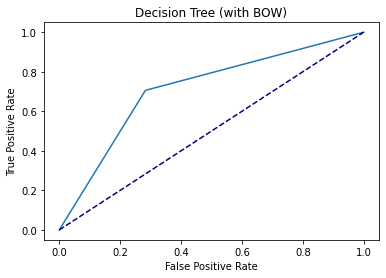

F1 Score: 0.7099473070270705


array([ 1,  1,  1, ...,  1, -1, -1], dtype=int64)

In [16]:
get_preds(test_bow, train_bow, 
        test_sentiment, train_sentiment, 
        DecisionTreeClassifier(random_state=4248), 
        'Decision Tree (with BOW)', 'decision_tree_bow')

AUC: 0.702


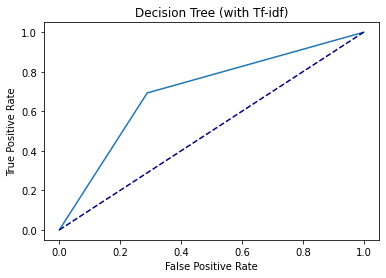

F1 Score: 0.699281504803423


array([ 1, -1,  1, ..., -1, -1,  1], dtype=int64)

In [17]:
get_preds(test_tfidf, train_tfidf,
        test_sentiment, train_sentiment, 
        DecisionTreeClassifier(random_state=4248), 
        'Decision Tree (with Tf-idf)', 'decision_tree_tfidf')

AUC: 0.84516


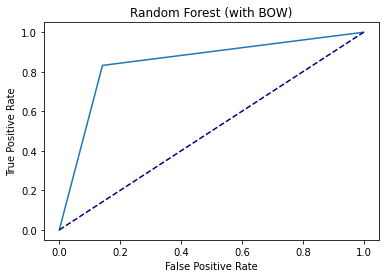

F1 Score: 0.8431332820034849


array([ 1,  1,  1, ..., -1,  1, -1], dtype=int64)

In [18]:
get_preds(test_bow, train_bow, 
        test_sentiment, train_sentiment, 
        RandomForestClassifier(random_state=4248),
        'Random Forest (with BOW)', 'random_forest_bow')

AUC: 0.846


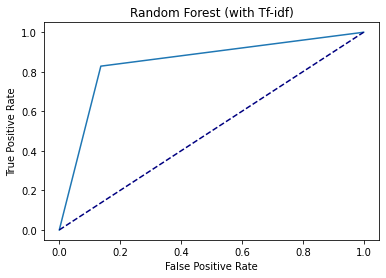

F1 Score: 0.843253806693266


array([ 1,  1,  1, ..., -1,  1,  1], dtype=int64)

In [19]:
get_preds(test_tfidf, train_tfidf,
        test_sentiment, train_sentiment, 
        RandomForestClassifier(random_state=4248),
        'Random Forest (with Tf-idf)', 'random_forest_tfidf')

AUC: 0.68808


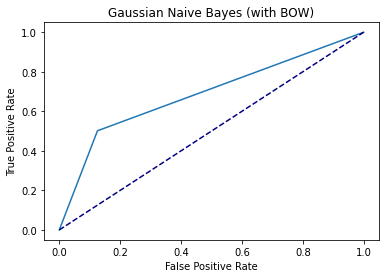

F1 Score: 0.6165798013570657


array([-1,  1,  1, ...,  1, -1, -1], dtype=int64)

In [20]:
get_preds(test_bow, train_bow, 
        test_sentiment, train_sentiment,
        GaussianNB(), 
        'Gaussian Naive Bayes (with BOW)', 'gaussian_nb_bow')

AUC: 0.76152


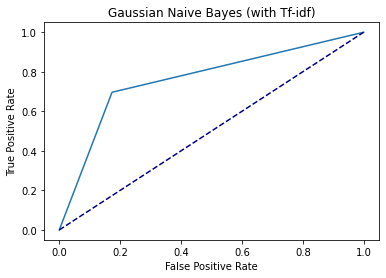

F1 Score: 0.7448866067608044


array([ 1,  1,  1, ...,  1, -1,  1], dtype=int64)

In [21]:
get_preds(test_tfidf.toarray(), train_tfidf.toarray(),
        test_sentiment, train_sentiment,
        GaussianNB(), 
        'Gaussian Naive Bayes (with Tf-idf)', 'gaussian_nb_tfidf')

AUC: 0.83968


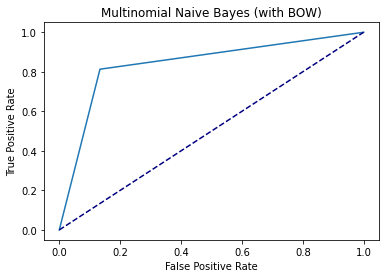

F1 Score: 0.835292183775787


In [22]:
preds_nb = get_preds(test_bow, train_bow, 
                  test_sentiment, train_sentiment,
                  MultinomialNB(),
                  'Multinomial Naive Bayes (with BOW)', 'multinomial_nb_bow')

AUC: 0.8419199999999999


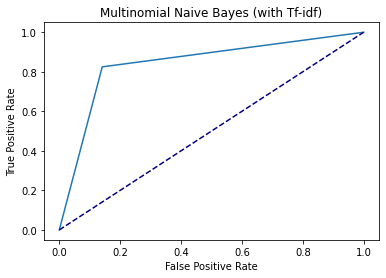

F1 Score: 0.8391927083333334


In [23]:
preds_nb = get_preds(test_tfidf.toarray(), train_tfidf.toarray(),
                  test_sentiment, train_sentiment,
                  MultinomialNB(),
                  'Multinomial Naive Bayes (with Tf-idf)', 'multinomial_nb_tfidf')

AUC: 0.83968


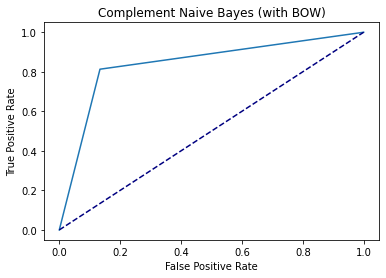

F1 Score: 0.835292183775787


In [24]:
preds_nb = get_preds(test_bow, train_bow, 
                  test_sentiment, train_sentiment,
                  ComplementNB(), 
                  'Complement Naive Bayes (with BOW)', 'complement_nb_bow')

AUC: 0.8419199999999999


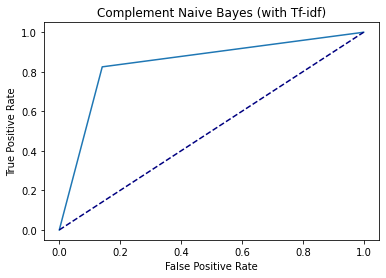

F1 Score: 0.8391927083333334


In [25]:
preds_nb = get_preds(test_tfidf.toarray(), train_tfidf.toarray(),
                  test_sentiment, train_sentiment,
                  ComplementNB(), 
                  'Complement Naive Bayes (with Tf-idf)', 'complement_nb_tfidf')

AUC: 0.8442


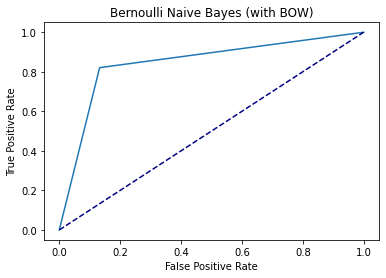

F1 Score: 0.8404930586838117


In [26]:
preds_nb = get_preds(test_bow, train_bow, 
                  test_sentiment, train_sentiment,
                  BernoulliNB(), 
                  'Bernoulli Naive Bayes (with BOW)', 'bernoulli_nb_bow')

AUC: 0.8442


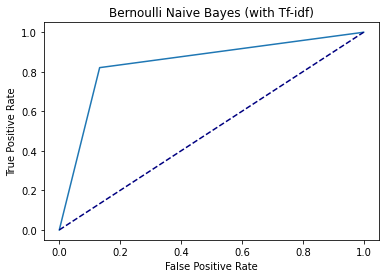

F1 Score: 0.8404930586838117


In [27]:
preds_nb = get_preds(test_tfidf.toarray(), train_tfidf.toarray(),
                  test_sentiment, train_sentiment,
                  BernoulliNB(), 
                  'Bernoulli Naive Bayes (with Tf-idf)', 'bernoulli_nb_tfidf')